## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2020-04-04 08:08:55--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2020-04-04 08:08:55--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8477ab2f4c3f18675f7cdaf437.dl.dropboxusercontent.com/cd/0/inline/A1O6RiyE0KfDyxgUXb8t_DXT2mYwIqX3EmELfApudgdm36pZ5BRQfi3mhoNtfUwLfqnwph5waU-R2KtDjnb9OLmYIrRbfKCuKY167cBujzUlqA/file# [following]
--2020-04-04 08:08:56--  https://uc8477ab2f4c3f18675f7cdaf437.dl.dropboxusercontent.com/cd/0/inline/A1O6RiyE0KfDyxgUXb8t_DXT2mYwIqX3EmELfApudgdm36pZ5BRQfi3mhoNtfUwLfqnwph5waU-R2KtDjnb9OLmYIrRbfKCuKY167cBujzUlqA/file
Resolving uc8477ab2f4c3

In [0]:
ls

BBBC018_v1_images-fixed/  dataset/  drive/     ptsemseg/     sample_data/
BBBC018_v1_outlines/      data.zip  meta.json  ptsemseg.zip


Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import imageio
%matplotlib inline

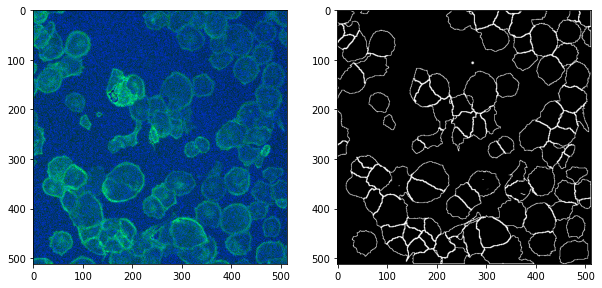

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
# im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
im = np.array(imageio.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
# mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
mask = (imageio.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.special import expit
from torch.utils.data import Dataset 
from PIL import Image
import random
from torchvision import transforms
import torch.utils.data as data_utils
import os
import time
from IPython import display  

# -------------
## Unet from https://github.com/milesial/Pytorch-UNet
Unet architecture (combination of down and up convolutions (mixed with batchnorm, nonlinearities, maxpooling, upsampling)) is good choice to be applied to segmentation tasks for high resolution images (512*512 in our case)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

## create paths to data

In [0]:
from os import listdir
from os.path import isfile, join

def get_file_list(mypath):
  files = [f for f in sorted(listdir(mypath)) if isfile(join(mypath, f))]
  train_paths = [mypath + s for s in files]
  return train_paths

train_img_paths = get_file_list('dataset/img/train/')
train_mask_paths = get_file_list('dataset/masks_machine/train/')

val_img_paths = get_file_list('dataset/img/val/')
val_mask_paths = get_file_list('dataset/masks_machine/val/')

print((train_img_paths))
print((train_mask_paths))

print((val_img_paths))
print(val_mask_paths)

['dataset/img/train/0000.jpg', 'dataset/img/train/0001.jpg', 'dataset/img/train/0002.jpg', 'dataset/img/train/0003.jpg', 'dataset/img/train/0008.jpg', 'dataset/img/train/0010.jpg', 'dataset/img/train/0011.jpg', 'dataset/img/train/0013.jpg', 'dataset/img/train/0014.jpg', 'dataset/img/train/0015.jpg', 'dataset/img/train/0016.jpg', 'dataset/img/train/0018.jpg', 'dataset/img/train/0019.jpg', 'dataset/img/train/0020.jpg', 'dataset/img/train/0022.jpg', 'dataset/img/train/0023.jpg', 'dataset/img/train/0024.jpg', 'dataset/img/train/0025.jpg', 'dataset/img/train/0026.jpg', 'dataset/img/train/0027.jpg', 'dataset/img/train/0028.jpg', 'dataset/img/train/0029.jpg', 'dataset/img/train/0031.jpg', 'dataset/img/train/0032.jpg', 'dataset/img/train/0033.jpg', 'dataset/img/train/0034.jpg', 'dataset/img/train/0035.jpg', 'dataset/img/train/0036.jpg', 'dataset/img/train/0037.jpg', 'dataset/img/train/0038.jpg', 'dataset/img/train/0039.jpg', 'dataset/img/train/0040.jpg', 'dataset/img/train/0041.jpg', 'dataset/

## Define transformations
Requires la ot of GPU memory, which is sad, probably could be applied sequaentially

In [0]:
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

img_transform = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation([-30, 30]),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4)(anchors),
#     transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

mask_transform = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation([-30, 30]),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4)(anchors),
#     transforms.RandomVerticalFlip(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(means, stds),
])

# Not anough memoty for more transforms :(((

In [0]:
class ImgDataset(data_utils.Dataset):
    def __init__(self, 
                 img_paths, 
                 mask_paths, 
                 img_transform=None, 
                 mask_transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.img_transform = img_transform
        self.mask_transform = mask_transform
    
    
    def __getitem__(self, index):
      # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        
        image_init = Image.open(self.img_paths[index])
        image = image_init.resize((256, 256))
        if self.img_transform:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            random.seed(seed) # apply this seed to img tranfsorms
            image = self.img_transform(image)        
        if not self.mask_paths: # for test images
            #return self.img_transform(image_init.resize((1500, 1500)))
            return image
        
        mask = Image.open(self.mask_paths[index]).resize((256, 256))
        if self.mask_transform:
            random.seed(seed)
            mask = self.mask_transform(mask)
            
#         mask = (np.array(mask, dtype=np.float32)[None, :, :] > 0).astype(np.float32)
        mask = np.array(mask)[:,:,0].astype(np.float32)
        
        return image, mask.reshape(1,256,256)

      
    def __len__(self):
        return len(self.img_paths)

In [0]:
train_dataset = ImgDataset(train_img_paths, train_mask_paths, img_transform=img_transform, mask_transform=mask_transform)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=8,
                                              shuffle=True,
                                              num_workers=10)

val_dataset = ImgDataset(val_img_paths, val_mask_paths, img_transform=val_transform, mask_transform=None)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=3,
                                            shuffle=False,
                                            num_workers=10)

In [0]:
print(train_dataset[10][0].shape, train_dataset[10][0].type())
print(train_dataset[10][1].shape, (train_dataset[10][1]).dtype) # it is numpy.ndarray

torch.Size([3, 256, 256]) torch.FloatTensor
(1, 256, 256) float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


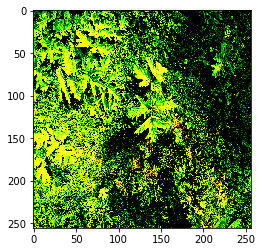

In [0]:
# print(train_dataset[15][0].permute(1,2,0).shape)
plt.imshow(train_dataset[15][0].permute(1,2,0))

(1, 256, 256)


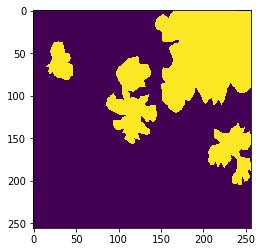

In [0]:
print(train_dataset[15][1].shape)
plt.imshow(train_dataset[15][1].reshape(256,256))

In [0]:
unet = UNet(n_channels=3, n_classes=1).cuda()

In [0]:
opt = torch.optim.Adam(unet.parameters(), lr=1e-3)
num_epochs = 100

train_loss = []
val_accuracy = []

In [0]:
# # slow down the learning rate for 30 more epochs
# opt = torch.optim.Adam(unet.parameters(), lr=0.1*1e-3)
# num_epochs = 30

In [0]:
for (X_batch, y_batch) in train_batch_gen:

    X_batch = Variable(X_batch).cuda(); print("X_batch.shape", X_batch.shape); print("X_batch.type", X_batch.type())
    y_batch = Variable(y_batch).cuda(); print("\ny_batch.shape", y_batch.shape); print("y_batch.type", y_batch.type())
    logits = unet(X_batch); print("\nlogits.shape", logits.shape); print("logits.type", logits.type()); 
    loss = F.binary_cross_entropy_with_logits(logits, y_batch)
    break

X_batch.shape torch.Size([16, 3, 256, 256])
X_batch.type torch.cuda.FloatTensor

y_batch.shape torch.Size([16, 1, 256, 256])
y_batch.type torch.cuda.FloatTensor

logits.shape torch.Size([16, 1, 256, 256])
logits.type torch.cuda.FloatTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


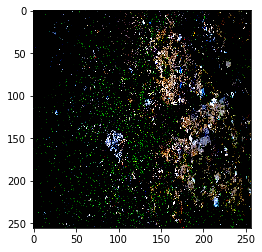

In [0]:
plt.imshow(X_batch[2].cpu().permute(1,2,0))

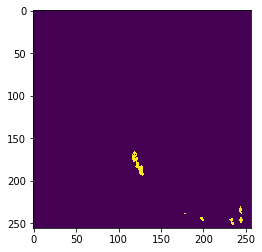

In [0]:
plt.imshow(y_batch[2].cpu().view(-1,256))

## Train

In [0]:
for epoch in range(num_epochs):
    start_time = time.time()
    unet.train(True)
    loss_batch = []
    for (X_batch, y_batch) in train_batch_gen:
        
        X_batch = Variable(X_batch).cuda()
        y_batch = Variable(y_batch).cuda()
        logits = unet(X_batch)
        loss = F.binary_cross_entropy_with_logits(logits, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()
        loss_batch.append(loss.data.cpu().numpy()) # [0]
    train_loss.append(np.mean(loss_batch))

    unet.train(False)
    val_iou = []
    for (X_batch, y_batch) in val_batch_gen:
        logits = unet(Variable(X_batch, volatile=True).cuda())
        y_pred = logits.data.cpu().numpy()
        val_iou.append(calc_iou(expit(y_pred) > 0.33, y_batch.numpy()))
    
    val_accuracy.append(np.mean(val_iou))
    # The results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))
    print("  validation iou:\t\t{:.2f} %".format(val_accuracy[-1] * 100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch 1 of 100 took 74.165s
  training loss (in-iteration): 	0.190791
  validation iou:		25.41 %
Epoch 2 of 100 took 72.444s
  training loss (in-iteration): 	0.191022
  validation iou:		41.63 %
Epoch 3 of 100 took 72.318s
  training loss (in-iteration): 	0.227268
  validation iou:		43.42 %
Epoch 4 of 100 took 71.812s
  training loss (in-iteration): 	0.180637
  validation iou:		41.10 %
Epoch 5 of 100 took 74.152s
  training loss (in-iteration): 	0.176109
  validation iou:		50.24 %
Epoch 6 of 100 took 73.060s
  training loss (in-iteration): 	0.176024
  validation iou:		32.07 %
Epoch 7 of 100 took 72.494s
  training loss (in-iteration): 	0.165911
  validation iou:		45.57 %
Epoch 8 of 100 took 72.399s
  training loss (in-iteration): 	0.160639
  validation iou:		47.35 %
Epoch 9 of 100 took 73.732s
  training loss (in-iteration): 	0.168478
  validation iou:		41.68 %


KeyboardInterrupt: ignored

In [0]:
torch.save(unet.state_dict(), 'checkpoint.pth')

In [0]:
unet = UNet(n_channels=3, n_classes=1).cuda()
unet.load_state_dict(torch.load('checkpoint.pth'))
# unet.eval()

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Test dataset

In [0]:
# test_img_paths = get_file_list('BBBC018_v1_images-fixed/test/')
test_img_paths = get_file_list('dataset/img/test/')
test_dataset = ImgDataset(test_img_paths, mask_paths=None, img_transform=val_transform, mask_transform=None)
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=1,
                                             shuffle=False,
                                             num_workers=3)

In [0]:
mask_list = []
for image in test_batch_gen:
    mask_list.append(expit(unet(Variable(image).cuda()).data.cpu().numpy()) > 0.30)
mask_list = np.array(mask_list)

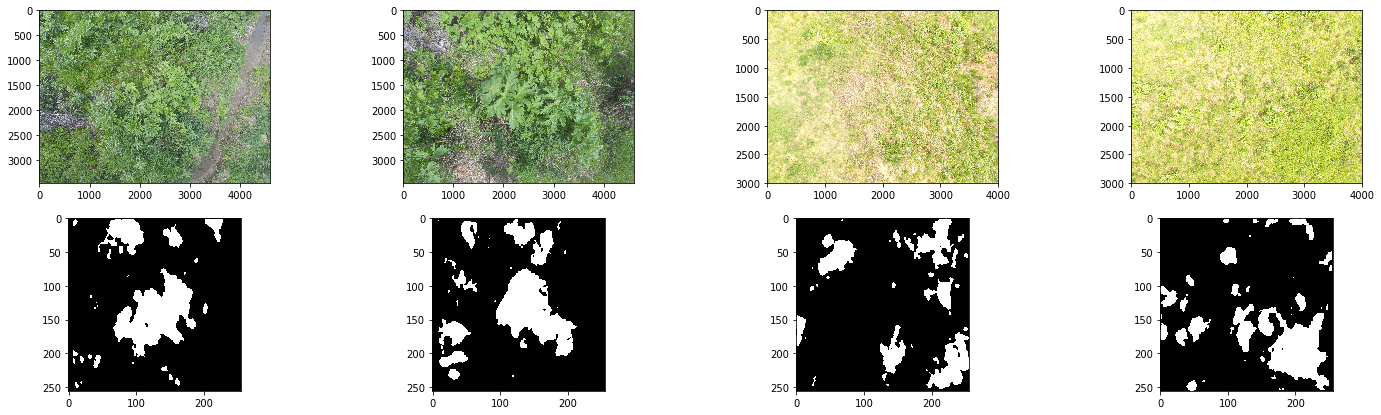

In [0]:
import imageio
plt.figure(figsize=(25,7))
for i, img_path, gt in zip(range(mask_list.shape[0]), test_img_paths, mask_list):
    plt.subplot(2, len(mask_list), i+1)
    plt.imshow(imageio.imread(img_path))
    plt.subplot(2, len(mask_list), i+1 + mask_list.shape[0])
    plt.imshow(gt[0, 0, :, :], 'gray')

The result is not that good, butit is possible to see some contours.

Probably more data and more augmentation could improve the performance

In [0]:
# import glob

# train_img_paths = sorted(glob.glob('BBBC018_v1_images-fixed/train/*.bmp'))
# train_img_paths_ = []
# for path in train_img_paths: train_img_paths_.append(path)
# train_img_paths = train_img_paths_
# train_mask_paths = sorted(glob.glob('BBBC018_v1_outlines/train/*.png'))
# train_mask_paths_ = []
# for path in train_mask_paths: train_mask_paths_.append(path); train_mask_paths = train_mask_paths_

# val_img_paths = glob.glob('BBBC018_v1_images-fixed/val/*.bmp')
# val_img_paths_ = []; 
# for path in val_img_paths: val_img_paths_.append(path); val_img_paths = val_img_paths_
# val_mask_paths = glob.glob('BBBC018_v1_outlines/val/*.png')
# val_mask_paths_ = []; 
# for path in val_mask_paths: val_mask_paths_.append(path); val_mask_paths = val_mask_paths_

# print((train_img_paths))
# print((train_mask_paths))

# print(val_img_paths)
# print(val_mask_paths)
# # train_dataset = MyDataset(train_img_paths, train_mask_paths, transform_X=transform_X, transform_Y=transform_Y)
# # val_dataset = MyDataset(val_img_paths, val_mask_paths, transform_X=transform_test, transform_Y=None)

['BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/00736-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03997-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03998-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/03999-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/04000-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05621-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05622-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05623-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05897-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05898-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/05900-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07314-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07315-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/07316-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09338-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09339-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/09340-actin.DIB.bmp', 'BBBC018_v1_images-fixed/train/10777-actin.DI